# Task 1 : Set up colab gpu runtime environment

In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 67.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 28.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 72.3 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=8dc6026e997ba61b59c464aaa64674271a7eb972cf38df7a9925df803b8fa6e7
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=77a3220cbf1d82106f84bd5bf586327bb62694d8474e0ba2c4e2cb91e8959962
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c6

# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [ ]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 587 (delta 1), pack-reused 0
Receiving objects: 100% (592/592), 13.60 MiB | 18.32 MiB/s, done.
Resolving deltas: 100% (3/3), done.


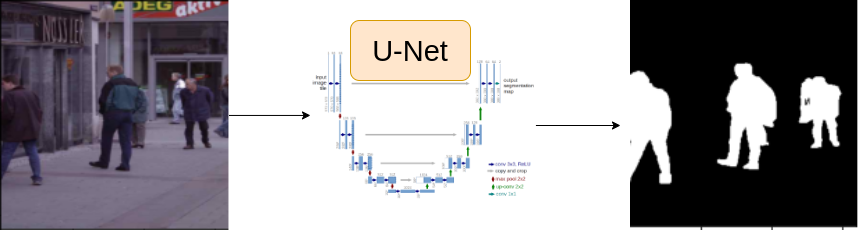

# Some Common Imports

In [ ]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [ ]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [ ]:
CSV_FILE = '/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = '/content/'

DEVICE = 'cuda' #because we are going to use GPU

#remote control of the project
EPOCHS = 25
LR = 0.003 #learning rate
IMAGE_SIZE = 320
BATCH_SIZE = 16

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [ ]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [ ]:
row = df.iloc[4]

image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0

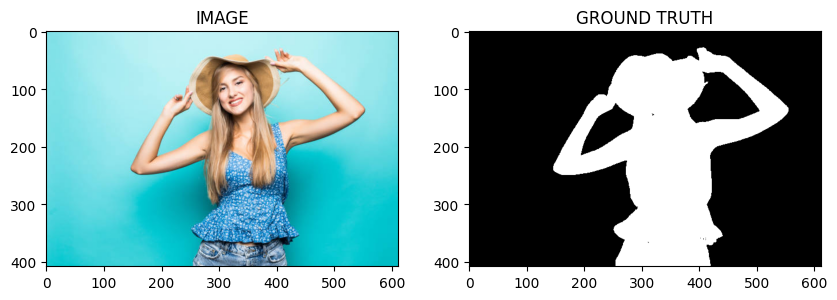

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [ ]:
train_df, valid_df = train_test_split(df, test_size = 0.2, random_state = 42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [ ]:
import albumentations as A

In [ ]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE, IMAGE_SIZE), #resize dimension
      A.HorizontalFlip(p = 0.5), #50% chance of horizontal flip of image
      A.VerticalFlip(p = 0.5) #50% chance of vertical flip of image
  ], is_check_shapes = False) #changed isCheckShapes to see if get shape dimension error

def get_valid_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE, IMAGE_SIZE), #resize dimension
  ], is_check_shapes = False)

# Task 4 : Create Custom Dataset

In [ ]:
from torch.utils.data import Dataset


In [ ]:
class SegmentationDataset(Dataset): #inherit dataset class
  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]

    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) #shape of (hieght, weight, channel)
    mask = np.expand_dims(mask, axis = -1)

    if self.augmentations:
      data = self.augmentations(image = image, mask = mask)
      image = data['image']
      mask = data['mask']

    #(h, w, c) -> (c, h, w) #eg for c --> idx 2 to idx 0

    image = np.transpose(image, (2, 0, 1)).astype(np.float32)
    mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)

    #numpy to tensor
    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask) / 255.0)

    return image, mask

In [ ]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [ ]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


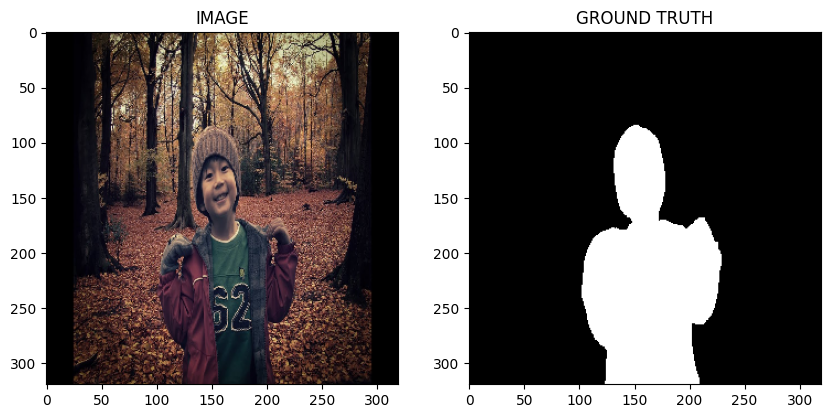

In [ ]:
idx = 21

image, mask = trainset[idx]
helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [ ]:
from torch.utils.data import DataLoader


In [ ]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)

In [ ]:
print(f"total no. of batches in trainloader : {len(trainloader)}")
print(f"total no. of batches in validloader : {len(validloader)}")

total no. of batches in trainloader : 15
total no. of batches in validloader : 4


In [ ]:
for image, mask in trainloader:
  break #just process one image, mask then break

print(f"One batch image shape: {image.shape}")
print(f"One batch mask shape: {mask.shape}")

One batch image shape: torch.Size([16, 3, 320, 320])
One batch mask shape: torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [ ]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss


In [ ]:
class SegmentationModel(nn.Module):
  def __init__(self):
    super(SegmentationModel, self).__init__()

  #^^ basic stuff in Pytorch
    self.arc =  smp.Unet(
        encoder_name = ENCODER,
        encoder_weights = WEIGHTS,
        in_channels = 3,
        classes = 1,
        activation = None
    )

  def forward(self, images, masks = None):
    logits = self.arc(images)

    if masks != None:
      loss1 = DiceLoss(mode='binary')(logits, masks)
      loss2 = nn.BCEWithLogitsLoss()(logits, masks)
      return logits, loss1 + loss2

    return logits


In [ ]:
model = SegmentationModel()
model.to(DEVICE)

SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
           

# Task 7 : Create Train and Validation Function

In [ ]:
def train_fn(data_loader, model, optimizer):
  model.train()
  total_loss = 0.0

  for images, masks in tqdm(data_loader):
    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(data_loader)

In [ ]:
def eval_fn(data_loader, model):
  model.eval()
  total_loss = 0.0

  with torch.no_grad():
    for images, masks in tqdm(data_loader):
      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      logits, loss = model(images, masks)

      total_loss += loss.item()

  return total_loss / len(data_loader)

# Task 8 : Train Model

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [ ]:
best_valid_loss = np.Inf

for i in range(EPOCHS):
  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print("SAVED-MODEL")
    best_valid_loss = valid_loss

  print(f"Epoch : {i+1} Train_loss : {train_loss} Valid_loss : {valid_loss}")


100%|██████████| 4/4 [00:00<00:00,  4.92it/s]


SAVED-MODEL
Epoch : 1 Train_loss : 0.7398294091224671 Valid_loss : 2.212162494659424


100%|██████████| 4/4 [00:00<00:00,  4.04it/s]


SAVED-MODEL
Epoch : 2 Train_loss : 0.3595452149709066 Valid_loss : 1.1753296107053757


100%|██████████| 4/4 [00:00<00:00,  4.98it/s]


SAVED-MODEL
Epoch : 3 Train_loss : 0.30875287552674613 Valid_loss : 0.3373434580862522


100%|██████████| 4/4 [00:00<00:00,  5.18it/s]


SAVED-MODEL
Epoch : 4 Train_loss : 0.2638476232687632 Valid_loss : 0.2945760190486908


100%|██████████| 4/4 [00:00<00:00,  4.00it/s]


SAVED-MODEL
Epoch : 5 Train_loss : 0.26914996405442554 Valid_loss : 0.23888875544071198


100%|██████████| 4/4 [00:00<00:00,  5.18it/s]


SAVED-MODEL
Epoch : 6 Train_loss : 0.2276205430428187 Valid_loss : 0.2148137018084526


100%|██████████| 4/4 [00:00<00:00,  5.10it/s]


SAVED-MODEL
Epoch : 7 Train_loss : 0.17961727877457936 Valid_loss : 0.2001361958682537


100%|██████████| 4/4 [00:00<00:00,  5.08it/s]


Epoch : 8 Train_loss : 0.152128866314888 Valid_loss : 0.2144918367266655


100%|██████████| 4/4 [00:00<00:00,  5.07it/s]


SAVED-MODEL
Epoch : 9 Train_loss : 0.15621956487496694 Valid_loss : 0.18575511127710342


100%|██████████| 4/4 [00:01<00:00,  3.38it/s]


Epoch : 10 Train_loss : 0.16019282390673956 Valid_loss : 0.22688814997673035


100%|██████████| 4/4 [00:00<00:00,  5.09it/s]


SAVED-MODEL
Epoch : 11 Train_loss : 0.15053720076878865 Valid_loss : 0.1505061835050583


100%|██████████| 4/4 [00:00<00:00,  5.09it/s]


Epoch : 12 Train_loss : 0.19304857552051544 Valid_loss : 0.32660631090402603


100%|██████████| 4/4 [00:00<00:00,  5.05it/s]


Epoch : 13 Train_loss : 0.1815293331940969 Valid_loss : 0.2339658923447132


100%|██████████| 4/4 [00:00<00:00,  5.07it/s]


Epoch : 14 Train_loss : 0.1581246515115102 Valid_loss : 0.2033587507903576


100%|██████████| 4/4 [00:00<00:00,  4.10it/s]


Epoch : 15 Train_loss : 0.16081709116697313 Valid_loss : 0.2238827832043171


100%|██████████| 4/4 [00:00<00:00,  5.09it/s]


Epoch : 16 Train_loss : 0.11978683918714524 Valid_loss : 0.22800968028604984


100%|██████████| 4/4 [00:00<00:00,  5.06it/s]


Epoch : 17 Train_loss : 0.1241723914941152 Valid_loss : 0.21864796429872513


100%|██████████| 4/4 [00:00<00:00,  5.13it/s]


Epoch : 18 Train_loss : 0.16464435358842214 Valid_loss : 0.2886620983481407


100%|██████████| 4/4 [00:00<00:00,  5.16it/s]


Epoch : 19 Train_loss : 0.12970262219508488 Valid_loss : 0.29934271425008774


100%|██████████| 4/4 [00:01<00:00,  3.73it/s]


Epoch : 20 Train_loss : 0.12998863110939662 Valid_loss : 0.22240614518523216


100%|██████████| 4/4 [00:00<00:00,  5.15it/s]


Epoch : 21 Train_loss : 0.14247763454914092 Valid_loss : 0.2739156261086464


100%|██████████| 4/4 [00:00<00:00,  5.07it/s]


Epoch : 22 Train_loss : 0.12918951213359833 Valid_loss : 0.1995498351752758


100%|██████████| 4/4 [00:00<00:00,  5.12it/s]


Epoch : 23 Train_loss : 0.12876690924167633 Valid_loss : 0.24453337490558624


100%|██████████| 4/4 [00:00<00:00,  5.06it/s]


Epoch : 24 Train_loss : 0.10590144097805024 Valid_loss : 0.2418868988752365


100%|██████████| 4/4 [00:01<00:00,  3.73it/s]

Epoch : 25 Train_loss : 0.11808262517054875 Valid_loss : 0.19237056002020836


# Task 9 : Inference

In [ ]:
idx = 2

model.load_state_dict(torch.load('/content/best_model.pt'))

image, mask = validset[idx]

#unsqueeze to add extra dimenstion for batch as model takes (batch, channel, height, width)
logits_mask = model(image.to(DEVICE).unsqueeze(0)) #(c, h, w) -> (1, C, H, W)

pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5)*1.0


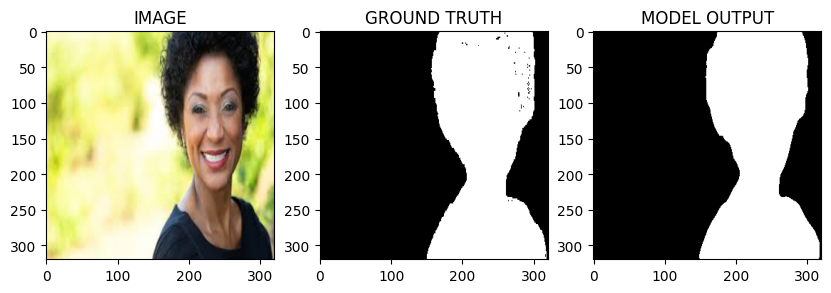

In [ ]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))